# Treating the Collected Canadian Data From the Stack Overflow Survey (2011 to 2023)

Clean the data. Need to deal with outliers, Null values, non uniform data format, etc.

## Setup

In [60]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
basePath = "../Canadian Data"
data = pd.read_csv(f"{basePath}/Stack Overflow/stack-overflow-canada.csv")
data

,Year,OrgSize,Industry,Experience,Title,Country,Salary
0,2023,100 to 499 employees,Other,2,Research & Development role,Canada,111527.0
1,2023,500 to 999 employees,"Information Services, IT, Software Development...",9,"Developer, back-end",Canada,101490.0
2,2023,NaN,Higher Education,NaN,"Developer, full-stack",Canada,NaN
3,2023,"Just me - I am a freelancer, sole proprietor, ...",NaN,25,"Developer, desktop or enterprise applications",Canada,NaN
4,2023,10 to 19 employees,"Information Services, IT, Software Development...",5,Data scientist or machine learning specialist,Canada,52046.0
...,...,...,...,...,...,...,...
19418,2011,Mature Small Business (25-100),Finance / Banking,41310,Web Application Developer,Canada,"$60,000 - $80,000"
19419,2011,Start Up (1-25),Web Services,41310,Web Application Developer,Canada,"$60,000 - $80,000"
19420,2011,Start Up (1-25),Web Services,11,Web Application Developer,Canada,"$40,000 - $60,000"
19421,2011,Mature Small Business (25-100),Web Services,41435,Web Application Developer,Canada,"$80,000 - $100,000"


## Data Cleaning 1 - NULL Values Treatment

In [62]:
cleanedData = data.copy()

### Null Values

In [63]:
def PrintNullValuesStat(df):
  print(df.isnull().mean())

In [64]:
PrintNullValuesStat(data)

Year          0.000000
OrgSize       0.236575
Industry      0.756783
Experience    0.170880
Title         0.116563
Country       0.000000
Salary        0.292282
dtype: float64


#### Salary

The salary is the most important data. Thus I will remove all the row with a null value in it. Since it correspond to only 30% of the data.

In [65]:
cleanedData = cleanedData[~cleanedData["Salary"].isna()]

In [66]:
PrintNullValuesStat(cleanedData)

Year          0.000000
OrgSize       0.073621
Industry      0.675978
Experience    0.003928
Title         0.008730
Country       0.000000
Salary        0.000000
dtype: float64


In [67]:
cleanedData.head()

,Year,OrgSize,Industry,Experience,Title,Country,Salary
0,2023,100 to 499 employees,Other,2,Research & Development role,Canada,111527.0
1,2023,500 to 999 employees,"Information Services, IT, Software Development...",9,"Developer, back-end",Canada,101490.0
4,2023,10 to 19 employees,"Information Services, IT, Software Development...",5,Data scientist or machine learning specialist,Canada,52046.0
5,2023,"Just me - I am a freelancer, sole proprietor, ...",NaN,50,Other (please specify):,Canada,185879.0
6,2023,"Just me - I am a freelancer, sole proprietor, ...",NaN,15,"Developer, front-end",Canada,350000.0


#### Title

Since there are not a lot of Title that are NA, I decided to drop them directly for simplicity.

In [68]:
cleanedData = cleanedData[~cleanedData["Title"].isna()]

#### OrgSize

Since there are not a lot of OrgSize that are NA, I decided to drop them directly for simplicity.

In [69]:
cleanedData = cleanedData[~cleanedData["OrgSize"].isna()]

#### Experience

Since there are not a lot of Experience that are NA, I decided to drop them directly for simplicity.

In [70]:
cleanedData = cleanedData[~cleanedData["Experience"].isna()]

#### Industry

Since a large amount of data are missing the industry, I will try to map them a value that I think will be suited. In most of the survey I have access to the proportion of people working in the different industry. Thus I will try to assign the different industries to the data in such way that will preserve these industries.

- 2023 Industry was given ✅ https://survey.stackoverflow.co/2023/#productivity-impacts-industry
- 2022 No info ❌
- 2021 No info ❌
- 2020 No info ❌
- 2019 the industry type was kept private, but the proportion are displayed there : https://insights.stackoverflow.com/survey/2019 ❌
- 2018 the industry type was kept private, but the proportion are displayed there : https://insights.stackoverflow.com/survey/2018 ❌
- 2017 ✅
- 2016 ✅
- 2015 ✅
- 2014 ✅
- 2013 ✅
- 2012 ✅
- 2011 ✅

In [71]:
cleanedData[cleanedData['Industry'].isna()].groupby("Year").size()

Year
2016       3
2017       1
2018    1097
2019    2177
2020    1293
2021    1718
2022    1475
2023     904
dtype: int64

In [72]:
def plotIndustry(df):
  # Assuming df has the "Industry" column
  industry_counts = df.groupby("Industry").size()
  industry_counts = industry_counts.sort_values(ascending=False)
  # Plotting the bar chart
  industry_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
  plt.title('Industry Distribution in 2023')
  plt.xlabel('Industry')
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()

In [73]:
def fillIndustry(df,industryProportions,indexOfIndustryColumn,defaultValueToFill):
  emptyIndustryRows = df[df["Industry"].isna()].copy()
  # Compute the number of rows to change for each industry type from the original null dataframe
  # Create a map for each pair -> IndustryType:NumberOfRowsToChange
  numberRowToChangePerIndustry = dict()

  for key, value in industryProportions.items():
      numberRowToChangePerIndustry[key] = math.floor(len(emptyIndustryRows) * industryProportions[key]/100)

  # get the current null dataframe
  currentIndex = 0
  for industryType, numberRowsToChange in numberRowToChangePerIndustry.items():
    # Select random rows
    for index in range(numberRowsToChange):
      # Change the null values
      if (currentIndex >= len(emptyIndustryRows)):
        break

      emptyIndustryRows.iloc[currentIndex, indexOfIndustryColumn] = industryType
      currentIndex += 1

    emptyIndustryRows["Industry"].fillna(defaultValueToFill, inplace=True)

  return emptyIndustryRows

In [74]:
yearToIndustryProportion = {
  2023:{
    "Information Services, IT, Software Development, or other Technology": 50,
    "Financial Services": 12,
    "Other": 11,
    "Manufacturing, Transportation, or Supply Chain": 7,
    "Healthcare": 6,
    "Retail and Consumer Services": 5,
    "Higher Education": 3,
    "Advertising Services": 2,
    "Insurance": 1,
    "Oil & Gas": 1,
    "Legal Services": 1,
    "Wholesale": 1,
  },
  2022:{
    "Information Services, IT, Software Development, or other Technology": 50,
    "Financial Services": 12,
    "Other": 11,
    "Manufacturing, Transportation, or Supply Chain": 7,
    "Healthcare": 6,
    "Retail and Consumer Services": 5,
    "Higher Education": 3,
    "Advertising Services": 2,
    "Insurance": 1,
    "Oil & Gas": 1,
    "Legal Services": 1,
    "Wholesale": 1,
  },
  2021:{
    "Information Services, IT, Software Development, or other Technology": 50,
    "Financial Services": 12,
    "Other": 11,
    "Manufacturing, Transportation, or Supply Chain": 7,
    "Healthcare": 6,
    "Retail and Consumer Services": 5,
    "Higher Education": 3,
    "Advertising Services": 2,
    "Insurance": 1,
    "Oil & Gas": 1,
    "Legal Services": 1,
    "Wholesale": 1,
  },
  2020:{
    "Information Services, IT, Software Development, or other Technology": 50,
    "Financial Services": 12,
    "Other": 11,
    "Manufacturing, Transportation, or Supply Chain": 7,
    "Healthcare": 6,
    "Retail and Consumer Services": 5,
    "Higher Education": 3,
    "Advertising Services": 2,
    "Insurance": 1,
    "Oil & Gas": 1,
    "Legal Services": 1,
    "Wholesale": 1,
  },
  2019: {
    "Information Services, IT, Software Development, or other Technology": 48,
    "Financial Services": 9,
    "Other": 8,
    "Manufacturing, Transportation, or Supply Chain": 5,
    "Healthcare": 4,
    "Retail and Consumer Services": 5,
    "Higher Education": 6,
    "Advertising Services": 5,
    "Insurance": 2,
    "Oil & Gas": 2,
    "Legal Services": 4,
    "Wholesale": 2
  },
  2018:{
    "Information Services, IT, Software Development, or other Technology": 59,
    "Financial Services": 9,
    "Other": 17,
    "Manufacturing, Transportation, or Supply Chain": 0,
    "Healthcare": 5,
    "Retail and Consumer Services": 5,
    "Higher Education": 0,
    "Advertising Services": 5,
    "Insurance": 0,
    "Oil & Gas": 0,
    "Legal Services": 0,
    "Wholesale": 0
  }
}

In [75]:
for year, proportion in yearToIndustryProportion.items():
  yearData = cleanedData[cleanedData['Year'] == year].copy()
  filledIndustry = fillIndustry(yearData,proportion,2,"Information Services, IT, Software Development, or other Technology")
  yearData.loc[yearData["Industry"].isna(), "Industry"] = filledIndustry["Industry"]
  cleanedData.loc[cleanedData["Year"]==year, "Industry"] = yearData["Industry"]

##### Drop the NA for 2016 and 2017

In [76]:
cleanedData = cleanedData[~cleanedData["Industry"].isna()]

## Data Integration 1 - Standardization of the Data

Treating the Non-Meaningfull Data

### Title

#### Student Problem

In [77]:
cleanedData = cleanedData[~cleanedData['Title'].str.contains('student', case=False)]

#### Multiple Role Problem

Sometime a person has many title, separated with ";". I will split these role and store an array of each title of the person. I will remove the row if the person has selected more than 3 roles. For each role in the array I will create a single instance of this person in the dataset.

In [78]:
cleanedData["Title"] = cleanedData['Title'].str.split(';')
cleanedData = cleanedData[cleanedData['Title'].str.len()<=3]
cleanedData = cleanedData.explode('Title', ignore_index=True)

In [79]:
noLeadingWhiteSpace = cleanedData.copy()
noLeadingWhiteSpace["Title"] = noLeadingWhiteSpace['Title'].str.lstrip()
cleanedData = noLeadingWhiteSpace.copy()

#### Removal of the "I don't work in tech"

Since we are only interested in tech industry job, these data are not relevant for us.

In [80]:
cleanedData = cleanedData[~(cleanedData["Title"]=="I don't work in tech")]

#### Grouping Similar Role but With Different Names

I will map all the title that differs from the 2023 title set and map them to this set. To make the analysis easier and normalize the different title. I made it in 3 steps because ChatGPT was not able to have 100% coverage with the first try.

In [81]:
# Coming from ChatGPT
mapping_dict = {
    'Senior executive/VP': 'Senior Executive (C-Suite, VP, etc.)',
    'Full-stack developer': 'Developer, full-stack',
    'Back-end developer': 'Developer, back-end',
    'Front-end developer': 'Developer, front-end',
    'Desktop or enterprise applications developer': 'Developer, desktop or enterprise applications',
    'Embedded applications or devices developer': 'Developer, embedded applications or devices',
    'Game or graphics developer': 'Developer, game or graphics',
    'Mobile developer': 'Developer, mobile',
    'Educator or academic researcher': 'Educator',
    'QA or test developer': 'Developer, QA or test',
    'C-suite executive (CEO, CTO, etc.)': 'Senior Executive (C-Suite, VP, etc.)',
    'Web developer': 'Developer, front-end',  # Assuming web developers are front-end developers
    'Database administrator': 'Database administrator',
    'DevOps specialist': 'DevOps specialist',
    'Systems administrator': 'System administrator',
    'Developer with a statistics or mathematics background': 'Other (please specify):',
    'Embedded applications/devices developer': 'Developer, embedded applications or devices',
    'Quality assurance engineer': 'Developer, QA or test',
    'Graphics programming': 'Developer, game or graphics',
    'Other': 'Other (please specify):',
    'Mobile developer - Android': 'Mobile developer',
    'Mobile developer - iOS': 'Mobile developer',
    'Executive (VP of Eng., CTO, CIO, etc.)': 'Senior Executive (C-Suite, VP, etc.)',
    'Full-stack web developer': 'Developer, full-stack',
    'Back-End Web Developer': 'Developer, back-end',
    'Front-End Web Developer': 'Developer, front-end',
    'Embedded Application Developer': 'Developer, embedded applications or devices',
    'IT Staff / System Administrator': 'System administrator',
    'Enterprise Level Services': 'Enterprise level services developer',
    'Web Application Developer': 'Developer, front-end',  # Assuming web developers are front-end developers
    'Systems Analyst': 'Data or business analyst',
    'Desktop Application Developer': 'Developer, desktop or enterprise applications',
    'Kernel / Driver Developer': 'Developer, embedded applications or devices',
    'IT Manager': 'Engineering manager',
    'Server Programmer': 'Developer, embedded applications or devices'
}

cleanedData['Title'] = cleanedData['Title'].replace(mapping_dict)

In [82]:
# Coming from ChatGPT
mapping_dict = {
    'Desktop applications developer': 'Developer, desktop or enterprise applications',
    'Graphic designer': 'Designer',
    'Machine learning developer': 'Machine learning specialist',
    'other': 'Other (please specify):',
    'Desktop developer': 'Developer, desktop or enterprise applications',
    'Back-end web developer': 'Developer, back-end',
    'Front-end web developer': 'Developer, front-end',
    'Mobile developer': 'Developer, mobile',
    'Embedded application developer': 'Developer, embedded applications or devices',
    'Quality Assurance': 'Developer, QA or test',
    'Analyst': 'Data or business analyst',
    'Growth hacker': 'Marketing or sales professional',
    'Business intelligence or data warehousing expert': 'Data or business analyst',
    'DevOps': 'DevOps specialist',
    'Enterprise level services developer': 'Developer, embedded applications or devices',
    'Mobile developer - Windows Phone': 'Developer, mobile',
    'Graphics programmer': 'Developer, game or graphics',
    'Machine learning specialist': 'Data scientist or machine learning specialist',
    'Desktop Software Developer': 'Developer, desktop or enterprise applications',
    'Manager of Developers or Team Leader': 'Engineering manager',
    'Full-Stack Web Developer': 'Developer, full-stack',
    'Executive (VP of Eng, CTO, CIO, etc.)': 'Senior Executive (C-Suite, VP, etc.)',
    'Mobile Application Developer': 'Developer, mobile'
}

cleanedData['Title'] = cleanedData['Title'].replace(mapping_dict)

In [83]:
mapping_dict = {
    'Data scientist': 'Data scientist or machine learning specialist',
    'Machine learning specialist': 'Data scientist or machine learning specialist',
}

cleanedData['Title'] = cleanedData['Title'].replace(mapping_dict)

In [84]:
cleanedData.groupby("Title").size()

Title
Academic researcher                                98
Blockchain                                         13
Cloud infrastructure engineer                     109
Data or business analyst                          239
Data scientist or machine learning specialist     327
Database administrator                            199
Designer                                          187
DevOps specialist                                 532
Developer Advocate                                  5
Developer Experience                                6
Developer, QA or test                             200
Developer, back-end                              2574
Developer, desktop or enterprise applications    1091
Developer, embedded applications or devices       481
Developer, front-end                             1707
Developer, full-stack                            3925
Developer, game or graphics                       232
Developer, mobile                                 656
Educator              

#### Removal of Non-Desired Title

In [85]:
roleToRemove = ['Other (please specify):', 'Developer Advocate','Blockchain', 'Marketing or sales professional']
cleanedData = cleanedData[~(cleanedData["Title"].isin(roleToRemove))]

In [86]:
cleanedData["Title"].unique()

array(['Research & Development role', 'Developer, back-end',
       'Data scientist or machine learning specialist',
       'Developer, front-end', 'Developer, full-stack',
       'Developer, QA or test', 'Data or business analyst',
       'Engineer, data', 'Engineering manager', 'Security professional',
       'Developer, game or graphics',
       'Developer, desktop or enterprise applications',
       'DevOps specialist', 'Developer, embedded applications or devices',
       'Cloud infrastructure engineer', 'Developer, mobile', 'Scientist',
       'System administrator', 'Educator', 'Product manager',
       'Hardware Engineer', 'Engineer, site reliability',
       'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)',
       'Project manager', 'Developer Experience',
       'Database administrator', 'Designer'], dtype=object)

### Experience

#### Range Problem

In [87]:
cleanedData["Experience"] = cleanedData["Experience"].astype(str)

Some Experience value comes in range and we want just the exact value. Thus I will replace all range with the middle value of the range.

In [88]:
cleanedData["Experience"].unique()

array(['2', '9', '5', '15', '22', '10', '21', '3', '8', '6', '26', '7',
       '20', '11', '25', '16', '12', '4', 'Less than 1 year', '18', '30',
       '23', '27', '32', '1', '28', '40', '13', '19', '17', '14', '35',
       '24', '42', '36', '29', '39', '37', '33', '38', '48', '41', '47',
       '31', '43', '46', '34', '44', '49', 'More than 50 years',
       '15-17 years', '6-8 years', '27-29 years', '0-2 years',
       '3-5 years', '30 or more years', '12-14 years', '18-20 years',
       '9-11 years', '24-26 years', '21-23 years', '10 to 11 years',
       '9 to 10 years', '8 to 9 years', 'Less than a year',
       '2 to 3 years', '4 to 5 years', '7 to 8 years', '5 to 6 years',
       '3 to 4 years', '14 to 15 years', '1 to 2 years', '17 to 18 years',
       '6 to 7 years', '12 to 13 years', '15 to 16 years',
       '11 to 12 years', '16 to 17 years', '20 or more years',
       '18 to 19 years', '13 to 14 years', '19 to 20 years', '13.0',
       '0.5', '3.5', '1.5', '8.0', '6/10/2014

##### Undesired value

In [89]:
valueToRemove = ['6/10/2014','50','More than 50 years', '2/5/2014', '2/5/2013', '6/10/2013', '41070', '40944', '41435', '41310']
cleanedData = cleanedData[~cleanedData['Experience'].isin(valueToRemove)]

##### Mapping the value

In [90]:
cleanedData["Experience"].dtype

dtype('O')

In [91]:
mapping_dict = {
    '<2': '1',
    'Less than 1 year': '0',
    '15-17 years': '16',
    '6-8 years': '7',
    '27-29 years': '28',
    '0-2 years': '1',
    '3-5 years': '4',
    '30 or more years': '30',
    '12-14 years': '13',
    '18-20 years': '19',
    '9-11 years': '10',
    '24-26 years': '25',
    '21-23 years': '22',
    '10 to 11 years': '10',
    '9 to 10 years': '9',
    '8 to 9 years': '8',
    '17 to 18 years': '17',
    'Less than a year': '0',
    '2 to 3 years': '2',
    '4 to 5 years': '4',
    '7 to 8 years': '7',
    '20 or more years': '20',
    '5 to 6 years': '5',
    '3 to 4 years': '3',
    '14 to 15 years': '14',
    '1 to 2 years': '1',
    '6 to 7 years': '6',
    '12 to 13 years': '12',
    '15 to 16 years': '15',
    '11 to 12 years': '11',
    '16 to 17 years': '16',
    '18 to 19 years': '18',
    '13 to 14 years': '13',
    '19 to 20 years': '19',
    '13.0': '13',
    '0.5': '0',
    '3.5': '3',
    '1.5': '1',
    '8.0': '8'
}


cleanedData['Experience'] = cleanedData['Experience'].replace(mapping_dict)

In [92]:
cleanedData.head()

,Year,OrgSize,Industry,Experience,Title,Country,Salary
0,2023,100 to 499 employees,Other,2,Research & Development role,Canada,111527.0
1,2023,500 to 999 employees,"Information Services, IT, Software Development...",9,"Developer, back-end",Canada,101490.0
2,2023,10 to 19 employees,"Information Services, IT, Software Development...",5,Data scientist or machine learning specialist,Canada,52046.0
4,2023,"Just me - I am a freelancer, sole proprietor, ...","Information Services, IT, Software Development...",15,"Developer, front-end",Canada,350000.0
5,2023,500 to 999 employees,Other,22,"Developer, full-stack",Canada,178443.0


#### Assigning Experience to Predefined Category

In [93]:
def mapExperienceToBin(experience):
  experienceBins = ["0-1", "2-4", "5-9", "10-*"]
  experienceToReturn = ""
  experienceToCompare = int(experience)
  if (experienceToCompare < 2):
    experienceToReturn = experienceBins[0]
  elif (experienceToCompare < 4):
    experienceToReturn = experienceBins[1]
  elif (experienceToCompare < 10):
    experienceToReturn = experienceBins[2]
  else:
    experienceToReturn = experienceBins[3]

  return experienceToReturn

cleanedData['Experience'] = cleanedData['Experience'].apply(mapExperienceToBin)

### OrgSize

In [94]:
cleanedData["OrgSize"].unique()

array(['100 to 499 employees', '500 to 999 employees',
       '10 to 19 employees',
       'Just me - I am a freelancer, sole proprietor, etc.',
       '1,000 to 4,999 employees', '20 to 99 employees',
       '10,000 or more employees', '2 to 9 employees',
       '5,000 to 9,999 employees', 'I don’t know', '2-9 employees',
       'Fewer than 10 employees', "I don't know",
       'I prefer not to answer', '10-19 employees', '100-499 employees',
       '20-99 employees', '1,000-4,999 employees', '5-9 employees',
       'I am not part of a company', '1-4 employees', '10,000+ employees',
       '5,000-9,999 employees', '500-999 employees', 'I am not sure',
       'Other (please specify)', '100', '6/15/2014', '1/5/2014', '16-30',
       '50-100', '31-50', '6/15/2013', '1/5/2013',
       'Fortune 1000 (1,000+)', 'Start Up (1-25)', 'Mid Sized (100-999)',
       'Mature Small Business (25-100)',
       'Other (not working, consultant, etc.)'], dtype=object)

#### Mixed Value Problem

##### Undesired Value

In [95]:
valueToRemove = ['Just me - I am a freelancer, sole proprietor, etc.',
 'I don’t know',  "I don't know",
 'I prefer not to answer', 'I am not part of a company',  'I am not sure',
 'Other (please specify)', '6/15/2014', '1/5/2014', '16-30',
 '50-100', '31-50', '6/15/2013', '1/5/2013',
 'Other (not working, consultant, etc.)'
]

cleanedData = cleanedData[~cleanedData['OrgSize'].isin(valueToRemove)]

##### Mapping the Value

In [96]:
{'2 to 9 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees',
    '500 to 999 employees', '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees'}

org_size_mapping = {
    '2 to 9 employees': '2 to 9 employees',
    '10 to 19 employees': '10 to 19 employees',
    '20 to 99 employees': '20 to 99 employees',
    '100 to 499 employees': '100 to 499 employees',
    '500 to 999 employees': '500 to 999 employees',
    '1,000 to 4,999 employees': '1,000 to 4,999 employees',
    '5,000 to 9,999 employees': '5,000 to 9,999 employees',
    '10,000 or more employees': '10,000 or more employees',
    '2-9 employees': '2 to 9 employees',
    'Fewer than 10 employees': '2 to 9 employees',
    '10-19 employees': '10 to 19 employees',
    '500-999 employees': '500 to 999 employees',
    '100-499 employees': '100 to 499 employees',
    '20-99 employees': '20 to 99 employees',
    '1,000-4,999 employees': '1,000 to 4,999 employees',
    '5-9 employees': '2 to 9 employees',
    '1-4 employees': '2 to 9 employees',
    '10,000+ employees': '10,000 or more employees',
    '5,000-9,999 employees': '5,000 to 9,999 employees',
    '100': '100 to 499 employees',
    'Fortune 1000 (1,000+)': '1,000 to 4,999 employees',
    'Mid Sized (100-999)': '100 to 499 employees',
    'Start Up (1-25)': '10 to 19 employees',
    'Mature Small Business (25-100)': '20 to 99 employees'
}

cleanedData['OrgSize'] = cleanedData['OrgSize'].replace(org_size_mapping)

In [97]:
cleanedData

,Year,OrgSize,Industry,Experience,Title,Country,Salary
0,2023,100 to 499 employees,Other,2-4,Research & Development role,Canada,111527.0
1,2023,500 to 999 employees,"Information Services, IT, Software Development...",5-9,"Developer, back-end",Canada,101490.0
2,2023,10 to 19 employees,"Information Services, IT, Software Development...",5-9,Data scientist or machine learning specialist,Canada,52046.0
5,2023,500 to 999 employees,Other,10-*,"Developer, full-stack",Canada,178443.0
6,2023,"1,000 to 4,999 employees","Information Services, IT, Software Development...",10-*,"Developer, back-end",Canada,118962.0
...,...,...,...,...,...,...,...
14482,2011,100 to 499 employees,Web Services,10-*,"Developer, front-end",Canada,"$80,000 - $100,000"
14483,2011,10 to 19 employees,Consulting,0-1,"Developer, desktop or enterprise applications",Canada,"$20,000 - $40,000"
14484,2011,20 to 99 employees,Web Services,10-*,"Developer, front-end",Canada,"$60,000 - $80,000"
14489,2011,10 to 19 employees,Web Services,10-*,"Developer, front-end",Canada,"$40,000 - $60,000"


### Industry

In [98]:
cleanedData[cleanedData["Year"]==2023]["Industry"].unique()

array(['Other',
       'Information Services, IT, Software Development, or other Technology',
       'Manufacturing, Transportation, or Supply Chain',
       'Financial Services', 'Healthcare', 'Insurance',
       'Advertising Services', 'Higher Education', 'Wholesale',
       'Oil & Gas', 'Retail and Consumer Services', 'Legal Services'],
      dtype=object)

#### Mixed Value Problem

##### Undesired Value

In [99]:
valueToRemove = ['Venture-funded startup',
    'Sole proprietorship or partnership, not in startup mode',
    'Government agency or public school/university',
    'Publicly-traded corporation',
    'Privately-held limited company, not in startup mode',
    "I don't know",
    'Something else',
    'Pre-series A startup',
    'I prefer not to answer',
    'Consulting',
    'Other (please specify)',
    'Not Currently Employed',
    'Foundation / Non-Profit',
    "Other"
]

cleanedData = cleanedData[~cleanedData["Industry"].isin(valueToRemove)]

##### Mapping the Value

In [100]:
industry_mapping = {
    'Other': 'Other',
    'Information Services, IT, Software Development, or other Technology': 'Information Services, IT, Software Development, or other Technology',
    'Manufacturing, Transportation, or Supply Chain': 'Manufacturing, Transportation, or Supply Chain',
    'Financial Services': 'Financial Services',
    'Healthcare': 'Healthcare',
    'Insurance': 'Insurance',
    'Advertising Services': 'Advertising Services',
    'Higher Education': 'Higher Education',
    'Wholesale': 'Wholesale',
    'Oil & Gas': 'Oil & Gas',
    'Retail and Consumer Services': 'Retail and Consumer Services',
    'Legal Services': 'Legal Services',

    'Non-profit/non-governmental organization or private school/university': 'Higher Education',
    'State-owned company': 'Legal Services',
    'Finance / Banking': 'Financial Services',
    'Manufacturing': 'Manufacturing, Transportation, or Supply Chain',
    'Government': 'Legal Services',

    'Software Products': 'Information Services, IT, Software Development, or other Technology',
    'Internet': 'Information Services, IT, Software Development, or other Technology',
    'Gaming': 'Information Services, IT, Software Development, or other Technology',
    'Web Services': 'Information Services, IT, Software Development, or other Technology',
    'Retail': 'Retail and Consumer Services',
    'Consumer Products': 'Retail and Consumer Services',
    'Media / Advertising': 'Advertising Services',
    'Telecommunications': 'Information Services, IT, Software Development, or other Technology',
    'Education': 'Higher Education',
    'Aerospace': 'Manufacturing, Transportation, or Supply Chain',
    'Automotive': 'Manufacturing, Transportation, or Supply Chain',
    'Defense': 'Legal Services',
    'Advertising': 'Advertising Services'
}

cleanedData['Industry'] = cleanedData['Industry'].replace(industry_mapping)

C:\Users\aiamo\AppData\Local\Temp\ipykernel_15936\2164641601.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedData['Industry'] = cleanedData['Industry'].replace(industry_mapping)


### Salary

#### Range Problem

In [101]:
salary_mapping = {
    "$80,000 - $100,000": 90000.0,
    "$40,000 - $60,000": 50000.0,
    "$60,000 - $80,000": 70000.0,
    ">$140,000": 150000,
    "$100,000 - $120,000": 110000.0,
    "$120,000 - $140,000": 130000.0,
    "$20,000 - $40,000": 30000.0,
    '<$20,000':20000.0
}
# Replace salary values with averages
cleanedData['Salary'] = cleanedData['Salary'].replace(salary_mapping)

C:\Users\aiamo\AppData\Local\Temp\ipykernel_15936\906228676.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedData['Salary'] = cleanedData['Salary'].replace(salary_mapping)


In [102]:
cleanedData['Salary'] = cleanedData['Salary'].astype(float)

C:\Users\aiamo\AppData\Local\Temp\ipykernel_15936\2365339092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedData['Salary'] = cleanedData['Salary'].astype(float)


In [103]:
cleanedData

,Year,OrgSize,Industry,Experience,Title,Country,Salary
1,2023,500 to 999 employees,"Information Services, IT, Software Development...",5-9,"Developer, back-end",Canada,101490.0
2,2023,10 to 19 employees,"Information Services, IT, Software Development...",5-9,Data scientist or machine learning specialist,Canada,52046.0
6,2023,"1,000 to 4,999 employees","Information Services, IT, Software Development...",10-*,"Developer, back-end",Canada,118962.0
7,2023,100 to 499 employees,"Manufacturing, Transportation, or Supply Chain",10-*,"Developer, full-stack",Canada,64686.0
8,2023,20 to 99 employees,"Information Services, IT, Software Development...",2-4,"Developer, full-stack",Canada,59481.0
...,...,...,...,...,...,...,...
14476,2011,10 to 19 employees,"Information Services, IT, Software Development...",10-*,"Developer, desktop or enterprise applications",Canada,150000.0
14482,2011,100 to 499 employees,"Information Services, IT, Software Development...",10-*,"Developer, front-end",Canada,90000.0
14484,2011,20 to 99 employees,"Information Services, IT, Software Development...",10-*,"Developer, front-end",Canada,70000.0
14489,2011,10 to 19 employees,"Information Services, IT, Software Development...",10-*,"Developer, front-end",Canada,50000.0


## Data Integration 2 - Mapping Salary to City

### City Mapping

In [104]:
# Salaries value are in the experience columns [0-1 => salary associated to 0 to 1 year of experience in CAD dollar]
salaryPerCityData = pd.read_csv(f"{basePath}/GovSalaryCombined.csv")
salaryPerCityData = salaryPerCityData.rename(columns={"Role":"Title"})
salaryPerCityData

,City,0-1,2-4,5-9,10-*,Title,Province,Group Size,Population
0,Toronto,62035.2,88617.6,105508.8,122400.0,"Senior Executive (C-Suite, VP, etc.)",Ontario,Large urban,5647656.0
1,Toronto,62035.2,88617.6,105508.8,122400.0,Engineering manager,Ontario,Large urban,5647656.0
2,Toronto,34560.0,66456.0,91036.8,115617.6,Educator,Ontario,Large urban,5647656.0
3,Toronto,62035.2,88617.6,105508.8,122400.0,Project manager,Ontario,Large urban,5647656.0
4,Toronto,46728.0,76147.2,97149.6,118152.0,DevOps specialist,Ontario,Large urban,5647656.0
...,...,...,...,...,...,...,...,...,...
350,Moncton–Richibucto,41054.4,56678.4,75657.6,94636.8,Database administrator,New Brunswick,Large urban,119785.0
351,Moncton–Richibucto,58219.2,77644.8,93664.8,109684.8,Product manager,New Brunswick,Large urban,119785.0
352,Moncton–Richibucto,31737.6,59083.2,77205.6,95328.0,Hardware Engineer,New Brunswick,Large urban,119785.0
353,Moncton–Richibucto,58219.2,77644.8,93664.8,109684.8,Engineering manager,New Brunswick,Large urban,119785.0


In [105]:
def CityMapper(row):
  # Match the closest salary of the person to closest average salary of the city
  experience = row["Experience"]
  title = row["Title"]
  salary = row["Salary"]

  salaryDataOfRole = salaryPerCityData[salaryPerCityData["Title"]==title][["City",experience,"Title"]].copy()

  salaryDataOfRole[experience] = (salaryDataOfRole[experience] - salary).abs()

  min_salary_row = salaryDataOfRole.loc[salaryDataOfRole[experience].idxmin()]

  return min_salary_row["City"]


cleanedData['City'] = cleanedData.apply(CityMapper, axis=1)

C:\Users\aiamo\AppData\Local\Temp\ipykernel_15936\3240983317.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedData['City'] = cleanedData.apply(CityMapper, axis=1)


In [106]:
cleanedData[cleanedData["City"].isna()]["Title"].unique()

array([], dtype=object)

In [107]:
cleanedData.head()

,Year,OrgSize,Industry,Experience,Title,Country,Salary,City
1,2023,500 to 999 employees,"Information Services, IT, Software Development...",5-9,"Developer, back-end",Canada,101490.0,Calgary
2,2023,10 to 19 employees,"Information Services, IT, Software Development...",5-9,Data scientist or machine learning specialist,Canada,52046.0,Halifax
6,2023,"1,000 to 4,999 employees","Information Services, IT, Software Development...",10-*,"Developer, back-end",Canada,118962.0,Calgary
7,2023,100 to 499 employees,"Manufacturing, Transportation, or Supply Chain",10-*,"Developer, full-stack",Canada,64686.0,Montreal
8,2023,20 to 99 employees,"Information Services, IT, Software Development...",2-4,"Developer, full-stack",Canada,59481.0,Hamilton–Niagara Peninsula


## Data Cleaning 2 - Salary Treatment

### Salary

#### Extreme Value Removal

##### Visualization

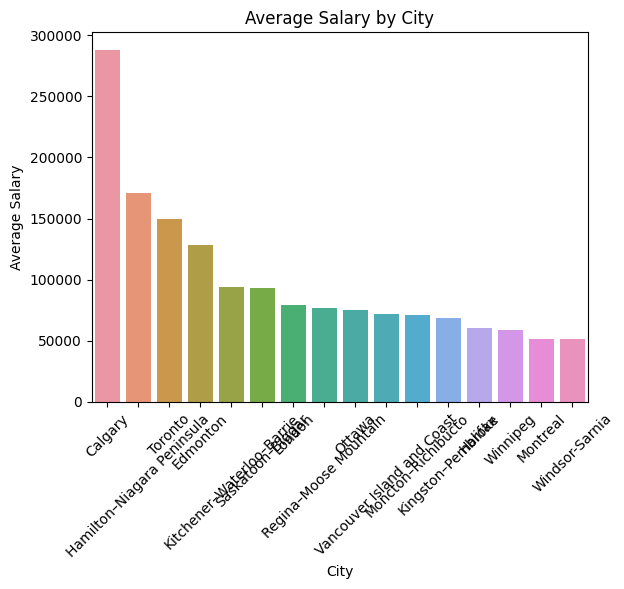

In [108]:
average_salary_by_city = cleanedData.groupby('City')['Salary'].mean().sort_values(ascending=False)

plt.figure()
sns.barplot(x=average_salary_by_city.index, y=average_salary_by_city.values)
plt.title('Average Salary by City')
plt.xlabel('City')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.show()

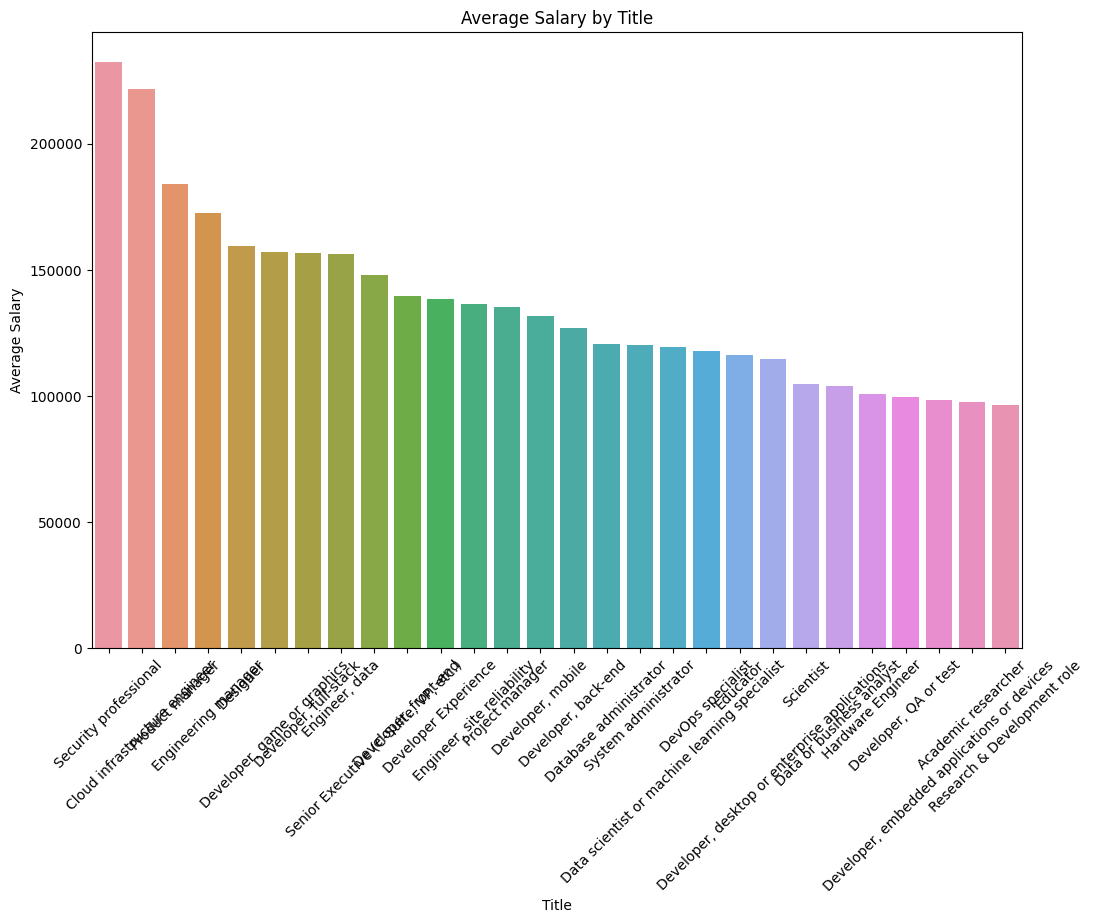

In [109]:
average_salary_by_title = cleanedData.groupby('Title')['Salary'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=average_salary_by_title.index, y=average_salary_by_title.values)
plt.title('Average Salary by Title')
plt.xlabel('Title')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.show()

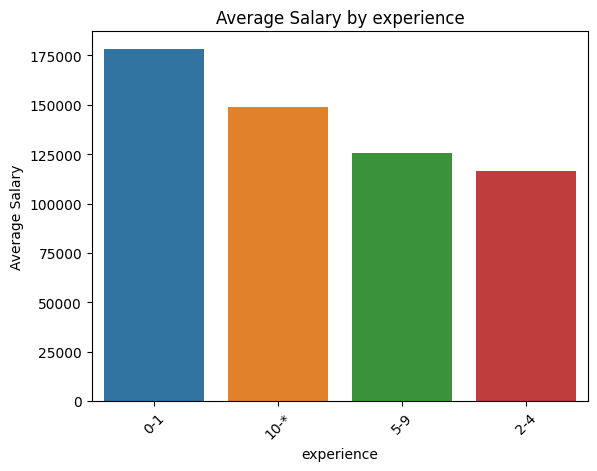

In [110]:
average_salary_by_experience = cleanedData.groupby('Experience')['Salary'].mean().sort_values(ascending=False)

plt.figure()
sns.barplot(x=average_salary_by_experience.index, y=average_salary_by_experience.values)
plt.title('Average Salary by experience')
plt.xlabel('experience')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.show()

##### Removal by Experience

After analysing the plot. I decide that I will remove outliers based on experience and salaries. It is not normal that 0-1 experience is the highest. I will remove outliers based on their standard deviation. There std will be computed based on the average salary and std of the canadian government data.

In [111]:
salaryPerCityData.head()

,City,0-1,2-4,5-9,10-*,Title,Province,Group Size,Population
0,Toronto,62035.2,88617.6,105508.8,122400.0,"Senior Executive (C-Suite, VP, etc.)",Ontario,Large urban,5647656.0
1,Toronto,62035.2,88617.6,105508.8,122400.0,Engineering manager,Ontario,Large urban,5647656.0
2,Toronto,34560.0,66456.0,91036.8,115617.6,Educator,Ontario,Large urban,5647656.0
3,Toronto,62035.2,88617.6,105508.8,122400.0,Project manager,Ontario,Large urban,5647656.0
4,Toronto,46728.0,76147.2,97149.6,118152.0,DevOps specialist,Ontario,Large urban,5647656.0


In [112]:
# Get the mean and std for each experience bin from salaryPerCityData
experienceAndMeanStd = {
    "0-1":(),
    "2-4":(),
    "5-9":(),
    "10-*":(),
}

for experience in experienceAndMeanStd:
  mean = salaryPerCityData[experience].mean()
  std = salaryPerCityData[experience].std()
  experienceAndMeanStd[experience] = (mean,std)

# The salaries of the survey are in USD and the canada governement salary are in CAD
usdToCadRate = 1.34

# compute the z-score for each of the rows based on the good std and mean
cleanedData['ZScore'] = cleanedData.apply(lambda row: ((row['Salary']*usdToCadRate) - experienceAndMeanStd[row['Experience']][0]) / experienceAndMeanStd[row['Experience']][1], axis=1)

# Keep all the z-score with distance <= |2|
cleanedData = cleanedData[cleanedData["ZScore"].abs() <= 2]

C:\Users\aiamo\AppData\Local\Temp\ipykernel_15936\531920216.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanedData['ZScore'] = cleanedData.apply(lambda row: ((row['Salary']*usdToCadRate) - experienceAndMeanStd[row['Experience']][0]) / experienceAndMeanStd[row['Experience']][1], axis=1)


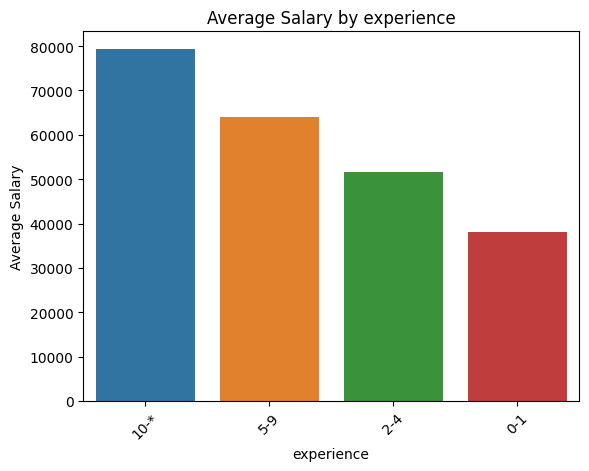

In [113]:
average_salary_by_experience = cleanedData.groupby('Experience')['Salary'].mean().sort_values(ascending=False)

plt.figure()
sns.barplot(x=average_salary_by_experience.index, y=average_salary_by_experience.values)
plt.title('Average Salary by experience')
plt.xlabel('experience')
plt.ylabel('Average Salary')
plt.xticks(rotation=45)
plt.show()

## Output

In [114]:
cleanedData.groupby("City").size()

City
Calgary                        245
Edmonton                        99
Halifax                        544
Hamilton–Niagara Peninsula    1238
Kingston–Pembroke              524
Kitchener–Waterloo–Barrie      493
London                         168
Moncton–Richibucto             199
Montreal                      1573
Ottawa                         115
Regina–Moose Mountain           59
Saskatoon–Biggar                77
Toronto                        728
Vancouver Island and Coast     293
Windsor-Sarnia                  17
Winnipeg                       666
dtype: int64

In [115]:
cleanedData

,Year,OrgSize,Industry,Experience,Title,Country,Salary,City,ZScore
2,2023,10 to 19 employees,"Information Services, IT, Software Development...",5-9,Data scientist or machine learning specialist,Canada,52046.0,Halifax,-0.749955
7,2023,100 to 499 employees,"Manufacturing, Transportation, or Supply Chain",10-*,"Developer, full-stack",Canada,64686.0,Montreal,-0.635981
8,2023,20 to 99 employees,"Information Services, IT, Software Development...",2-4,"Developer, full-stack",Canada,59481.0,Hamilton–Niagara Peninsula,0.987401
10,2023,20 to 99 employees,"Manufacturing, Transportation, or Supply Chain",5-9,Data or business analyst,Canada,63199.0,Halifax,0.064237
11,2023,100 to 499 employees,"Information Services, IT, Software Development...",5-9,"Developer, front-end",Canada,53533.0,Montreal,-0.641401
...,...,...,...,...,...,...,...,...,...
14464,2011,100 to 499 employees,"Information Services, IT, Software Development...",10-*,"Developer, front-end",Canada,90000.0,Toronto,0.789724
14466,2011,20 to 99 employees,"Information Services, IT, Software Development...",10-*,"Developer, desktop or enterprise applications",Canada,90000.0,Toronto,0.789724
14482,2011,100 to 499 employees,"Information Services, IT, Software Development...",10-*,"Developer, front-end",Canada,90000.0,Toronto,0.789724
14484,2011,20 to 99 employees,"Information Services, IT, Software Development...",10-*,"Developer, front-end",Canada,70000.0,Winnipeg,-0.336692


### Final Formating the Data

In [116]:
cleanedData = cleanedData.rename(columns={"OrgSize":"Company Size"})
cleanedData = cleanedData.drop("ZScore",axis=1)
experience_mapping = {
    '0-1': '0 to 1 years',
    '2-4': '2 to 4 years',
    '5-9': '5 to 9 years',
    '10-*': '10 or more years'
}

cleanedData['Experience'] = cleanedData['Experience'].map(experience_mapping)

In [121]:
cleanedData = cleanedData.rename(columns={"Salary":"Salary (USD)"})

In [123]:
cleanedData.to_csv(f'{basePath}/CanadaData.csv', index=False)